## Visualize heatmaps of differentially expressed genes

Visualize a heatmap of the differentially expressed genes using the original E-GEOD-51409 expression data versus the simulated expression data for the same experiment

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import ast
import pandas as pd
import numpy as np
import seaborn as sns
import random
import glob
from sklearn import preprocessing

sys.path.append("../")
from functions import utils
import generate_labeled_data

import warnings
warnings.filterwarnings(action='ignore')

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Read in config variables
config_file = os.path.abspath(os.path.join(os.getcwd(),"../configs", "config_Pa_experiment_limma.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load parameters
local_dir = params["local_dir"]
experiment_id = 'E-GEOD-51409'

In [4]:
# Input files
selected_original_data_file = os.path.join(
    local_dir,
    "pseudo_experiment",
    "selected_original_data_"+experiment_id+"_example.txt")

selected_simulated_data_file = os.path.join(
    local_dir,
    "pseudo_experiment",
    "selected_simulated_data_"+experiment_id+"_example.txt")

DE_stats_simulated_file = os.path.join(
    local_dir,
    "pseudo_experiment",
    "output_simulated",
    "DE_stats_simulated_data_"+experiment_id+"_example.txt")

DE_stats_original_file = os.path.join(
    local_dir,
    "pseudo_experiment",
    "output_original",
    "DE_stats_original_data_"+experiment_id+"_example.txt")

In [5]:
# Output files
base_dir = os.path.abspath(
  os.path.join(
      os.getcwd(), "../")) 

heatmap_original_file = os.path.join(
    base_dir,
    "Pseudomonas",
    "results",
    "DE_heatmap_original_"+experiment_id+"_example.png")

heatmap_simulated_file = os.path.join(
    base_dir,
    "Pseudomonas",
    "results",
    "DE_heatmap_simulated_"+experiment_id+"_example.png")

original_sign_DEG_file = os.path.join(
    base_dir,
    "Pseudomonas",
    "results",
    "sign_DEG_original_"+experiment_id+"_example.txt")

simulated_sign_DEG_file = os.path.join(
    base_dir,
    "Pseudomonas",
    "results",
    "sign_DEG_simulated_"+experiment_id+"_example.txt")

In [6]:
# Read data
selected_original_data = pd.read_table(
    selected_original_data_file,
    header=0,
    sep='\t',
    index_col=0)

selected_simulated_data = pd.read_table(
    selected_simulated_data_file,
    header=0,
    sep='\t',
    index_col=0)

DE_stats_simulated_data = pd.read_table(
    DE_stats_simulated_file,
    header=0,
    sep='\t',
    index_col=0)

DE_stats_original_data = pd.read_table(
    DE_stats_original_file,
    header=0,
    sep='\t',
    index_col=0)

DE_stats_simulated_data.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B
PA3229,0.998000,7.222000,79.792418,3.856255e-11,8.693838e-08,16.476386
PA4881,1.186667,6.110333,76.929079,4.912461e-11,8.693838e-08,16.271234
PA2493,0.884000,5.941000,72.033227,7.593662e-11,8.693838e-08,15.892463
PA4149,0.871333,6.905667,68.557790,1.053610e-10,8.693838e-08,15.599886
PA2359,0.931000,7.043167,68.351116,1.074888e-10,8.693838e-08,15.581817


In [7]:
# Get the number of genes that p-value < 0.05/5549
# AND log2FC > 1
sign_DEG_simulated = DE_stats_simulated_data[
    (abs(DE_stats_simulated_data['logFC'])>1) & (DE_stats_simulated_data['adj.P.Val']<0.05)]
print(sign_DEG_simulated.shape[0])

# Sort significant DEGs and select top 30 genes
sign_DEG_simulated.sort_values(by=['adj.P.Val'])
sign_DEG_simulated = sign_DEG_simulated.iloc[0:30,]

sign_DEG_simulated.to_csv(
        simulated_sign_DEG_file, float_format='%.3f', sep='\t')

sign_DEG_simulated.head(10)

14


,logFC,AveExpr,t,P.Value,adj.P.Val,B
PA4881,1.186667,6.110333,76.929079,4.912461e-11,8.693838e-08,16.271234
PA3126,1.008333,10.002167,67.210999,1.201542e-10,8.693838e-08,15.480725
PA1970,1.210000,6.100000,65.931078,1.364684e-10,8.693838e-08,15.364311
PA0896,-1.088333,8.500833,-53.982611,5.126838e-10,9.324276e-08,14.104194
PA2007,-1.213667,10.253833,-51.882139,6.666451e-10,1.109186e-07,13.844522
PA0865,-1.072333,9.780833,-51.497054,7.003267e-10,1.110318e-07,13.795465
PA5470,1.072333,7.252833,42.450286,2.512564e-09,1.640261e-07,12.492885
PA2008,-1.077000,10.449833,-39.991793,3.726671e-09,1.863276e-07,12.080373
PA2006,-1.168667,8.953333,-29.298450,2.902353e-08,4.421157e-07,9.873339
PA4354,1.149667,6.347167,26.432893,5.713547e-08,6.359023e-07,9.128563


In [8]:
DE_stats_original_data.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B
PA4175,-4.156000,10.562667,-42.035258,6.313727e-12,3.503487e-08,17.540678
PA0887,5.272667,9.499667,38.232066,1.518100e-11,4.211970e-08,16.849060
PA1914,-3.426667,9.025333,-32.831680,6.197397e-11,1.037664e-07,15.666580
PA0534,-3.213000,9.886167,-32.169062,7.480010e-11,1.037664e-07,15.502182
PA4648,-3.226000,10.733667,-31.139338,1.009716e-10,1.120582e-07,15.237142


In [9]:
# Get the number of genes that adj p-value < 0.05
# and log2FC > 1
adj_threshold = 0.05/5549
sign_DEG_original = DE_stats_original_data[
    (abs(DE_stats_original_data['logFC'])>1) & (DE_stats_original_data['adj.P.Val']<0.05)]
print(sign_DEG_original.shape[0])

# Sort significant DEGs and select top 30 genes
sign_DEG_original.sort_values(by=['adj.P.Val'])
sign_DEG_original = sign_DEG_original.iloc[0:14,]


sign_DEG_original.to_csv(
        original_sign_DEG_file, float_format='%.3f', sep='\t')

sign_DEG_original.head(10)

505


,logFC,AveExpr,t,P.Value,adj.P.Val,B
PA4175,-4.156000,10.562667,-42.035258,6.313727e-12,3.503487e-08,17.540678
PA0887,5.272667,9.499667,38.232066,1.518100e-11,4.211970e-08,16.849060
PA1914,-3.426667,9.025333,-32.831680,6.197397e-11,1.037664e-07,15.666580
PA0534,-3.213000,9.886167,-32.169062,7.480010e-11,1.037664e-07,15.502182
PA4648,-3.226000,10.733667,-31.139338,1.009716e-10,1.120582e-07,15.237142
PA3234,3.262667,8.826333,28.785259,2.083130e-10,1.926549e-07,14.583768
PA1245,2.901667,9.017500,28.003063,2.684290e-10,2.018870e-07,14.350732
PA1432,2.773000,9.649500,27.587966,3.079593e-10,2.018870e-07,14.223583
PA2939,-2.783667,10.368167,-27.258658,3.439175e-10,2.018870e-07,14.120936
PA0899,-3.250000,8.995000,-27.092334,3.638259e-10,2.018870e-07,14.068482


In [10]:
# Get gene ids for significant DEGs
sim_gene_ids = list(sign_DEG_simulated.index)
original_gene_ids = list(sign_DEG_original.index)

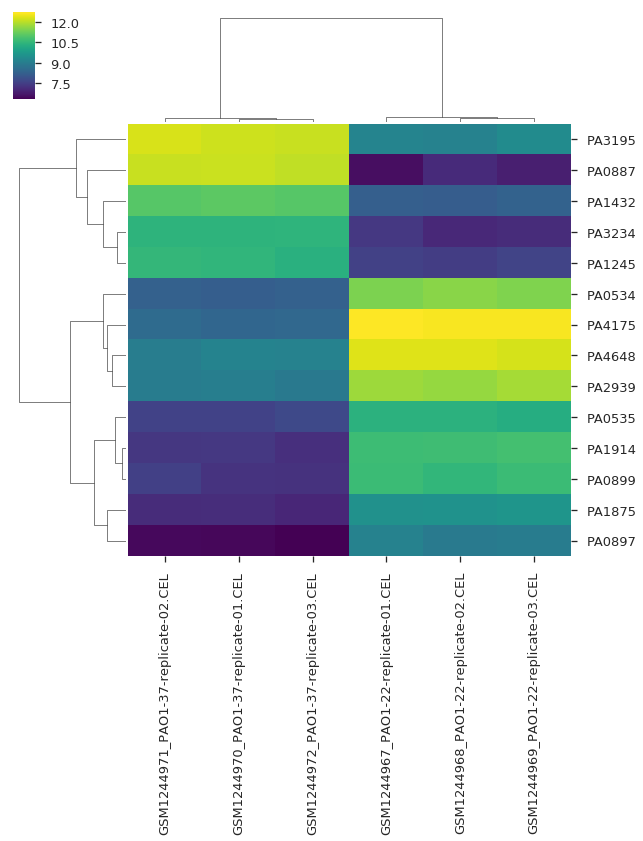

In [11]:
# Plot original data
selected_original_DEG_data = selected_original_data[original_gene_ids]
sns.set(style="ticks", context="talk")
f = sns.clustermap(selected_original_DEG_data.T, cmap="viridis")
f.savefig(heatmap_original_file, dpi=500)

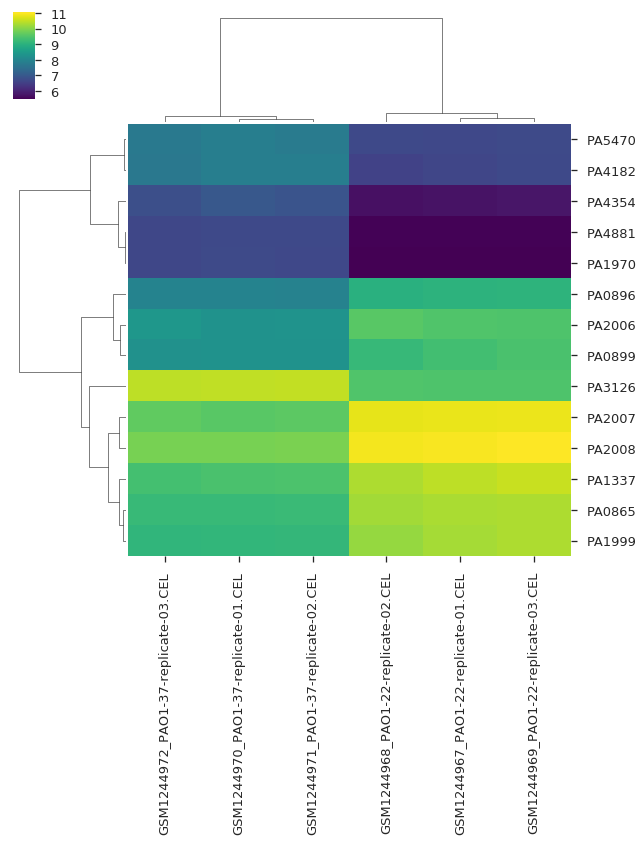

In [12]:
# Plot simulated
selected_simulated_DEG_data = selected_simulated_data[sim_gene_ids]
f = sns.clustermap(selected_simulated_DEG_data.T, cmap="viridis")
f.savefig(heatmap_simulated_file, dpi=500)